# Visualize the intermediate convnet outputs(activations)

Useful for understanding how successive convnet layers transform their input, and for getting
a first idea of the meaning of individual convnet filters.

In [14]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [15]:
# load one single picture as an example of visualization

img_path = 'C:/Users/acer/Desktop/QBS/tutorial week 6/FC/test/cats/cat.1700.jpg'
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)

# turn this image into an appropriate 4D tensor
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


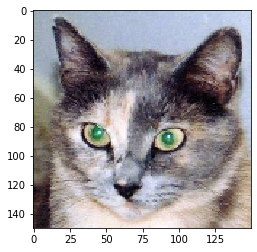

In [16]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [17]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] #extract the top 8 layer
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [30]:
# it will return a list of 5 numpy arrays
activations = activation_model.predict(img_tensor)
activations

[array([[[[0.02304764, 0.        , 0.02648033, ..., 0.02843241,
           0.00029226, 0.        ],
          [0.03078584, 0.        , 0.02318397, ..., 0.03268467,
           0.        , 0.        ],
          [0.03189799, 0.        , 0.02991868, ..., 0.02996004,
           0.0146865 , 0.        ],
          ...,
          [0.04497869, 0.        , 0.03808457, ..., 0.05225738,
           0.0099372 , 0.        ],
          [0.04353537, 0.        , 0.03193734, ..., 0.05312531,
           0.00497785, 0.        ],
          [0.04546764, 0.        , 0.03454983, ..., 0.05316174,
           0.00438683, 0.        ]],
 
         [[0.02326413, 0.        , 0.02749176, ..., 0.03001231,
           0.        , 0.        ],
          [0.03304457, 0.        , 0.02223526, ..., 0.03433127,
           0.        , 0.        ],
          [0.02865162, 0.        , 0.03202952, ..., 0.02952929,
           0.00498895, 0.        ],
          ...,
          [0.05083217, 0.        , 0.03586364, ..., 0.05399789,
   

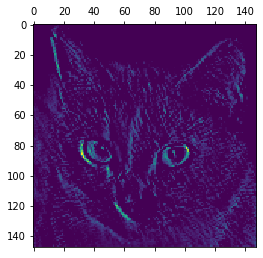

In [20]:
# visualizing some of the channels
import matplotlib.pyplot as plt

#contour of the cat
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

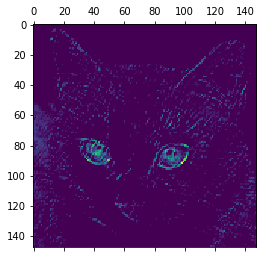

In [24]:
# eye of the cat
plt.matshow(first_layer_activation[0, :, :, 17], cmap='viridis')

C:\Users\acer\anaconda3\envs\cpu\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


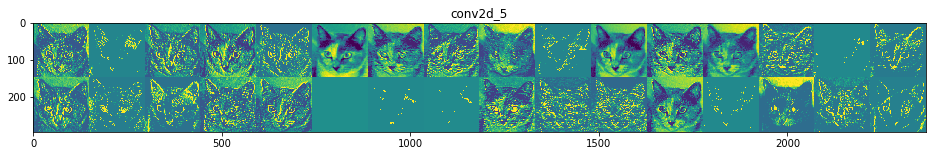

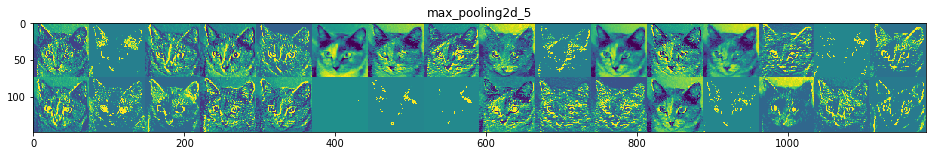

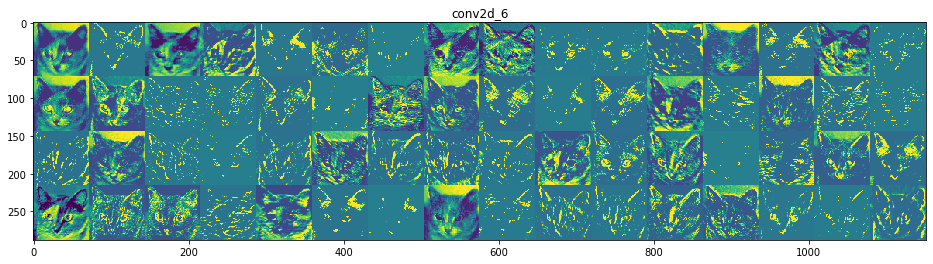

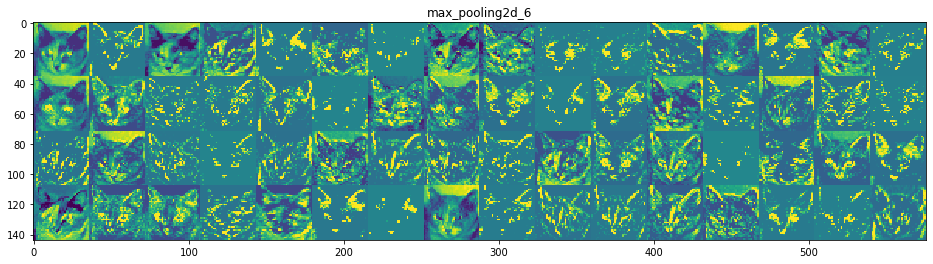

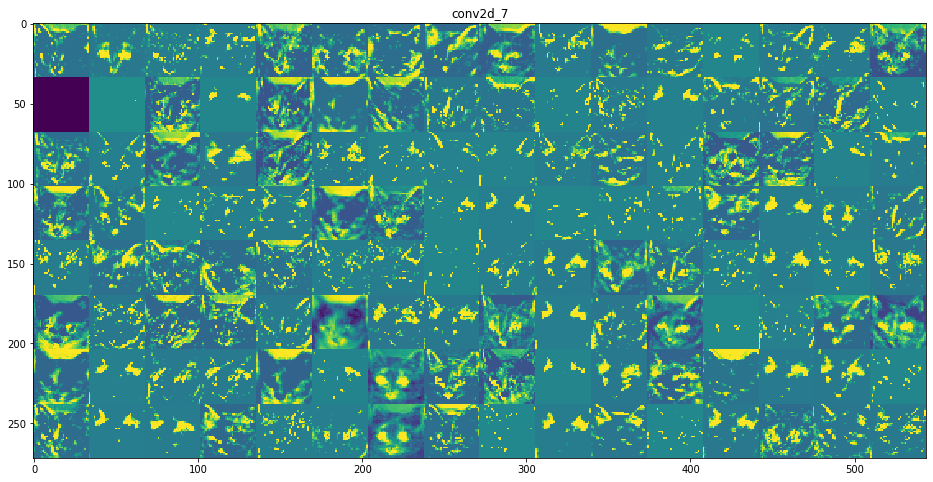

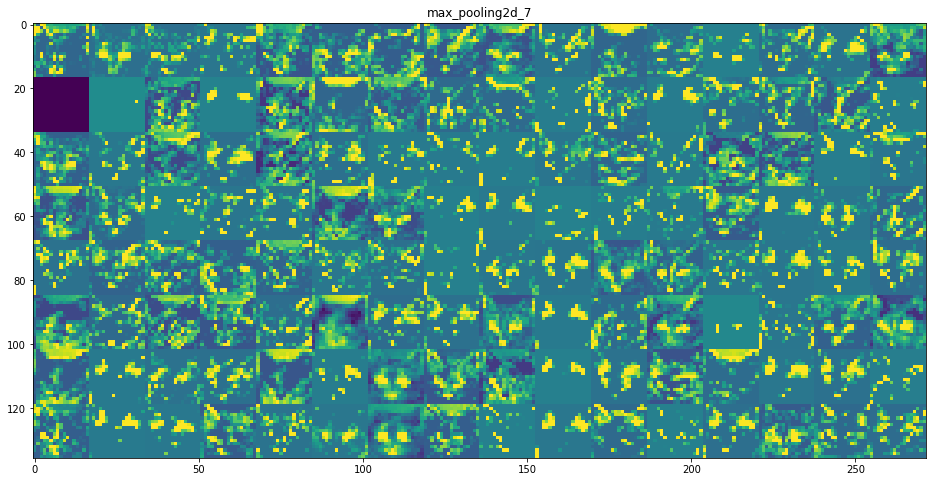

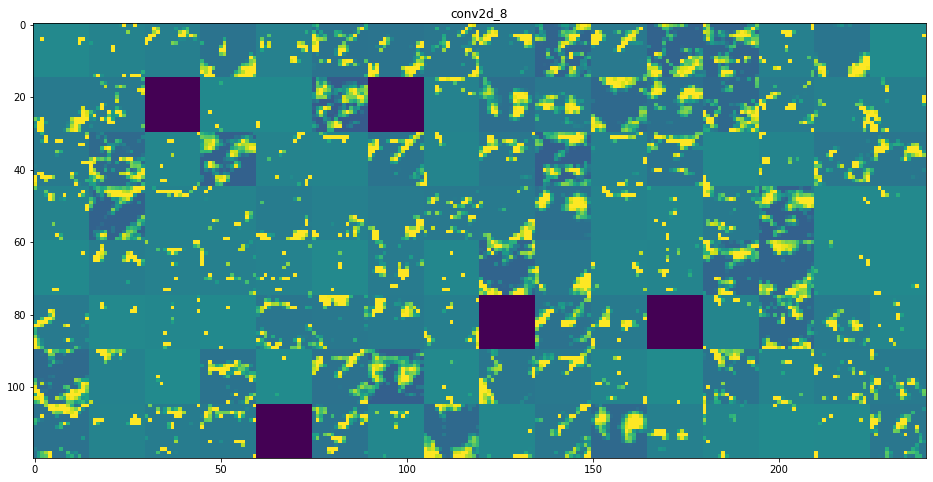

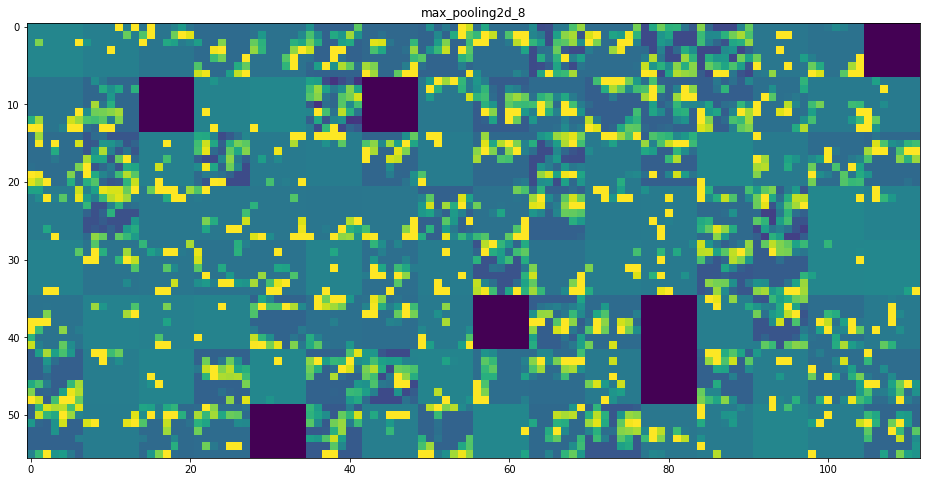

In [22]:
# record the names of layers
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16
    
for layer_name, layer_activation in zip(layer_names, activations):
    # number of features in the feature map (the last element in the shape)
    n_features = layer_activation.shape[-1]
    # number of images you put in the model
    size = layer_activation.shape[1]
    
    # how many columns do we need to show all the features
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            # the post-processing for the feature images we want to show
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,  
                         row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Visualize convnet filters

Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.

In [94]:
from keras.applications import VGG16
from keras import backend as K

# here’s a loss for the activation of filter 0 in the layer block3_conv1 of the
# VGG16 network, pretrained on ImageNet
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [95]:
grads = K.gradients(loss, model.input)[0]
grads

<tf.Tensor 'gradients_587/block1_conv1_5/convolution_grad/Conv2DBackpropInput:0' shape=(None, None, None, 3) dtype=float32>

In [96]:
# help the gradient-descent process go smoothly by normalizing the gradient tensor by dividing its L2-norm
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
# add 1e-5 to avoid the value being divided by 0

In [97]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [100]:
# use random function to generate some value between 0 and 1 and then rescale
# it will make the image start with grey
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
# do gradient ascent for 40 times
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [106]:
def deprocess_image(x):
    # Normalizes the tensor: centers on 0, ensures that std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # Clips to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # Convert to an RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [63]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # iterate is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of
    # two Numpy tensors: the loss value and the gradient value.
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
       loss_value, grads_value = iterate([input_img_data])
       input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

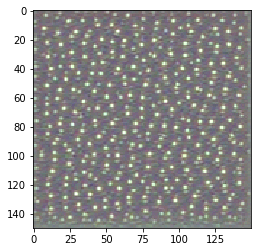

In [64]:
plt.imshow(generate_pattern('block3_conv1', 0))

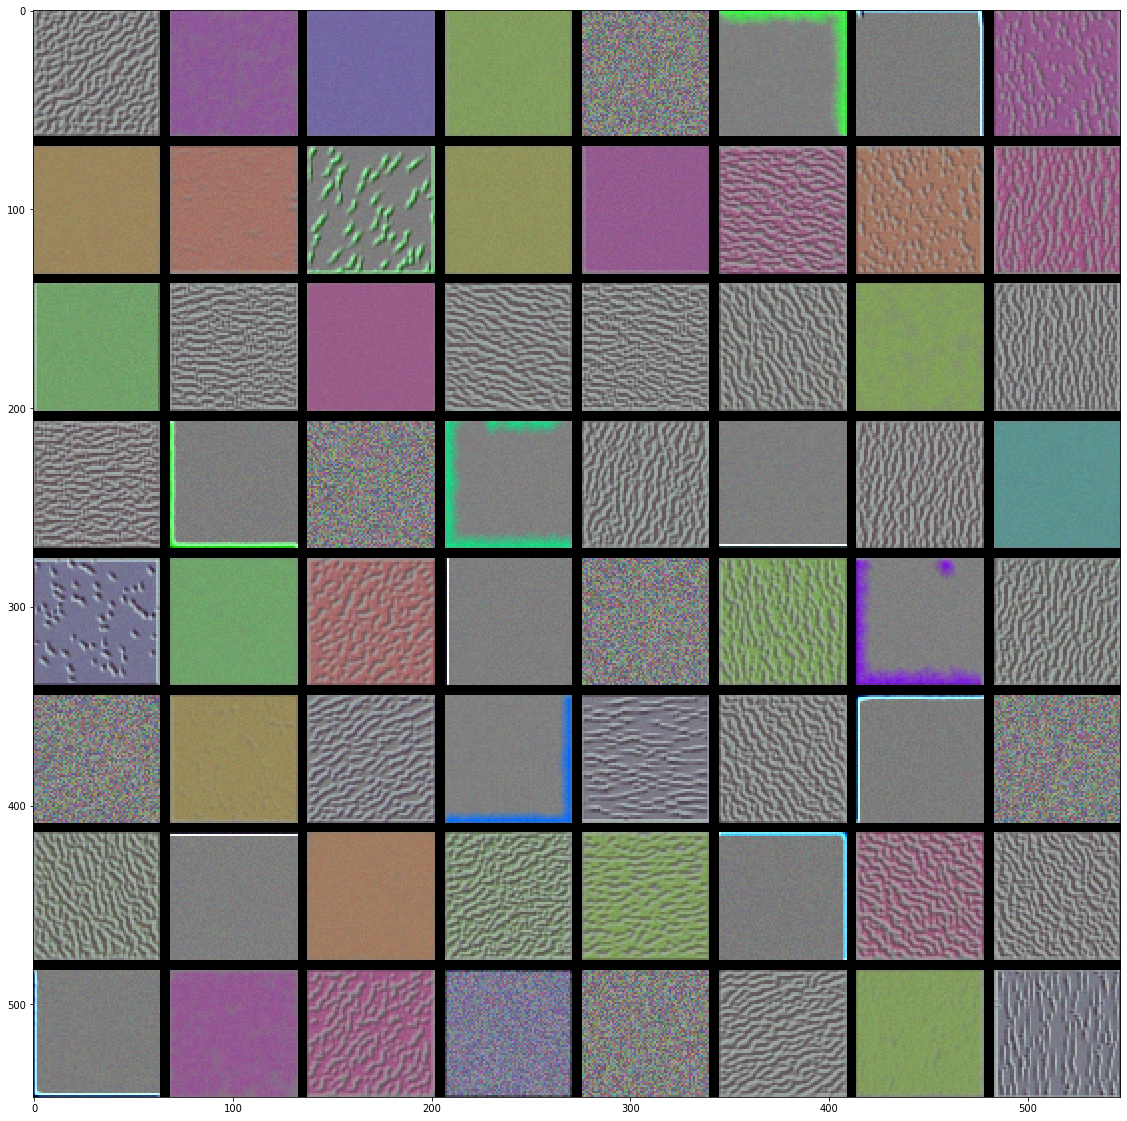

In [72]:
layer_name = 'block1_conv1'
# If you want to see features in another block, you can change the layer_name.

size = 64
margin = 5

# create a big tensor to store all information about your features
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        # define the size of every feature on the plot below
        # each feature is 64*69
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size

        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results.astype(np.uint8)) 
# You might encounter an error here. 
# Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
# Since our tensor takes value between 0 to 255, you need to change it into int.

# Class activation map (CAM) visualiztion

Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing
you to localize objects in images.

In [81]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [82]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

import numpy as np
img_path = 'C:/Users/acer/Desktop/QBS/tutorial week 6/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)

# Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# channel-wise color normalization
x = preprocess_input(x)

In [83]:
# run the pretrain model on the given image
# the prediction result of the elephant picture
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.86307), ('n01871265', 'tusker', 0.12587756), ('n02504013', 'Indian_elephant', 0.010834256)]


In [91]:
# The entry in the prediction vector that was maximally activated is the one corresponding 
# to the “African elephant” class, at index 386
np.argmax(preds[0])

386

In [85]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

# analyze the gradient of elephant image
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

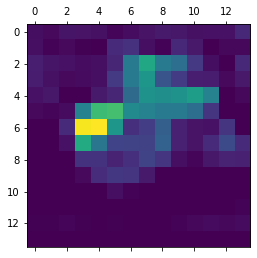

In [86]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [88]:
import cv2
img = cv2.imread(img_path)
# resize the heatmap to the same size as your image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# convert heatmap to RGB image
heatmap = np.uint8(255 * heatmap)
# put the heatmap on the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a factor of heatmap intensity
superimposed_img = heatmap * 0.4 + img 
# output the image
cv2.imwrite('C:/Users/acer/Desktop/QBS/tutorial week 6/elephant_heatmap.jpg', superimposed_img)

True

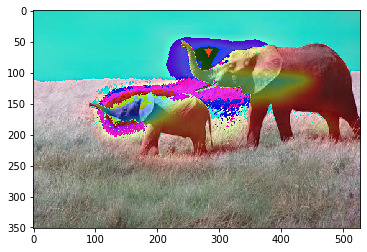

In [90]:
plt.imshow(superimposed_img.astype(np.uint8))